# Donor - Receiver Attribute Difference Analysis

In [36]:
# imports
import yaml
import pandas as pd

In [37]:
# read configuration (algorithm parameters etc) into dictionary
with open('../data/config.yaml', 'r') as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

## read in the attributes table for all donors and receivers

In [38]:
# read donor attributes
dtAttrDonor = pd.read_csv('../data/all_attrs_donors.csv')

# read receiver attributes
dtAttrReceiver = pd.read_csv('../data/all_attrs_receivers.csv')

print(dtAttrReceiver)

              id   p_mean  pet_mean  aridity   FMI  snow_frac  high_prec_freq  \
0        cat-100  1108.05   1014.29     0.92  0.08       0.26           21.33   
1      cat-10001  1190.29   1048.56     0.88  0.12       0.24           21.58   
2      cat-10005  1193.35   1039.99     0.87  0.13       0.25           20.92   
3      cat-10009  1252.00    999.19     0.80  0.20       0.26           21.17   
4      cat-10014  1136.71   1085.28     0.95  0.05       0.24           23.75   
...          ...      ...       ...      ...   ...        ...             ...   
14627    cat-999  1143.81   1028.16     0.90  0.10       0.27           20.75   
14628   cat-9990  1173.56   1048.97     0.89  0.11       0.24           22.08   
14629   cat-9991  1177.77   1045.30     0.89  0.11       0.24           21.25   
14630   cat-9992  1184.29   1062.43     0.90  0.10       0.24           21.67   
14631   cat-9995  1170.64   1054.27     0.90  0.10       0.24           22.17   

       low_prec_freq  high_

## Define the scenario and load donor-receiver pairing

In [70]:
# loop through regionalization algorithms and scenarios
statsAll = dfDiff = pd.DataFrame()
for reg_alg in ['kmeans_clust','kmedoids_clust','gower_dist','random_forest']:
    for reg_scenario in ['hlr', 'camels']:
        
        pair_file = '../output/donor_' + reg_scenario + '_' + reg_alg + '.csv'
        dtDonor =  pd.read_csv(pair_file)
        
        ## compute donor-receiver attribute difference
        # first merge receiver attributes with donor table
        dt1 = pd.merge(dtDonor[['id','tag','donor','distSpatial']], dtAttrReceiver[['id'] + config['attrs'][reg_scenario]],on='id')

        # then merge in donor attributes
        dt2 = pd.merge(dt1, dtAttrDonor[['id'] + config['attrs'][reg_scenario]],left_on='donor',right_on='id',suffixes=("_r", "_d"))

        # compute donor-receiver attribute difference
        for x in config['attrs'][reg_scenario]:
            dt2[x+'_diff'] = abs(dt2[x+'_d'] - dt2[x+'_r']).round(2)
        
        # add to the overall datafram for differences
        cols = [c1 for c1 in dt2.columns if c1.endswith("_diff")]
        dt2 = dt2[cols]
        #print(dt2.columns)
        dt2.columns = [x.replace("_diff","",1) for x in dt2.columns] 
        #print(dt2.columns)
        dt2.insert(0,column="reg_scenario",value=reg_scenario)
        dt2.insert(0,column="reg_algorithm",value=reg_alg)
        dfDiff = dfDiff.append(dt2)
                    
        # summarize donor-receiver attribute differences
        stats = None
        for a1 in config['attrs'][reg_scenario]:
            x = dt2[a1].describe().to_frame()
            x.columns = [a1]
            if stats is None:
                stats = x
            else:
                stats = stats.join(x)   
        stats.insert(0, column="reg_scenario",value=reg_scenario)
        stats.insert(0, column="reg_algorithm",value=reg_alg)
        
        statsAll = statsAll.append(stats)
        
statsAll.to_csv("../output/stats_donor_receiver_attribute_difference.csv", index=False)

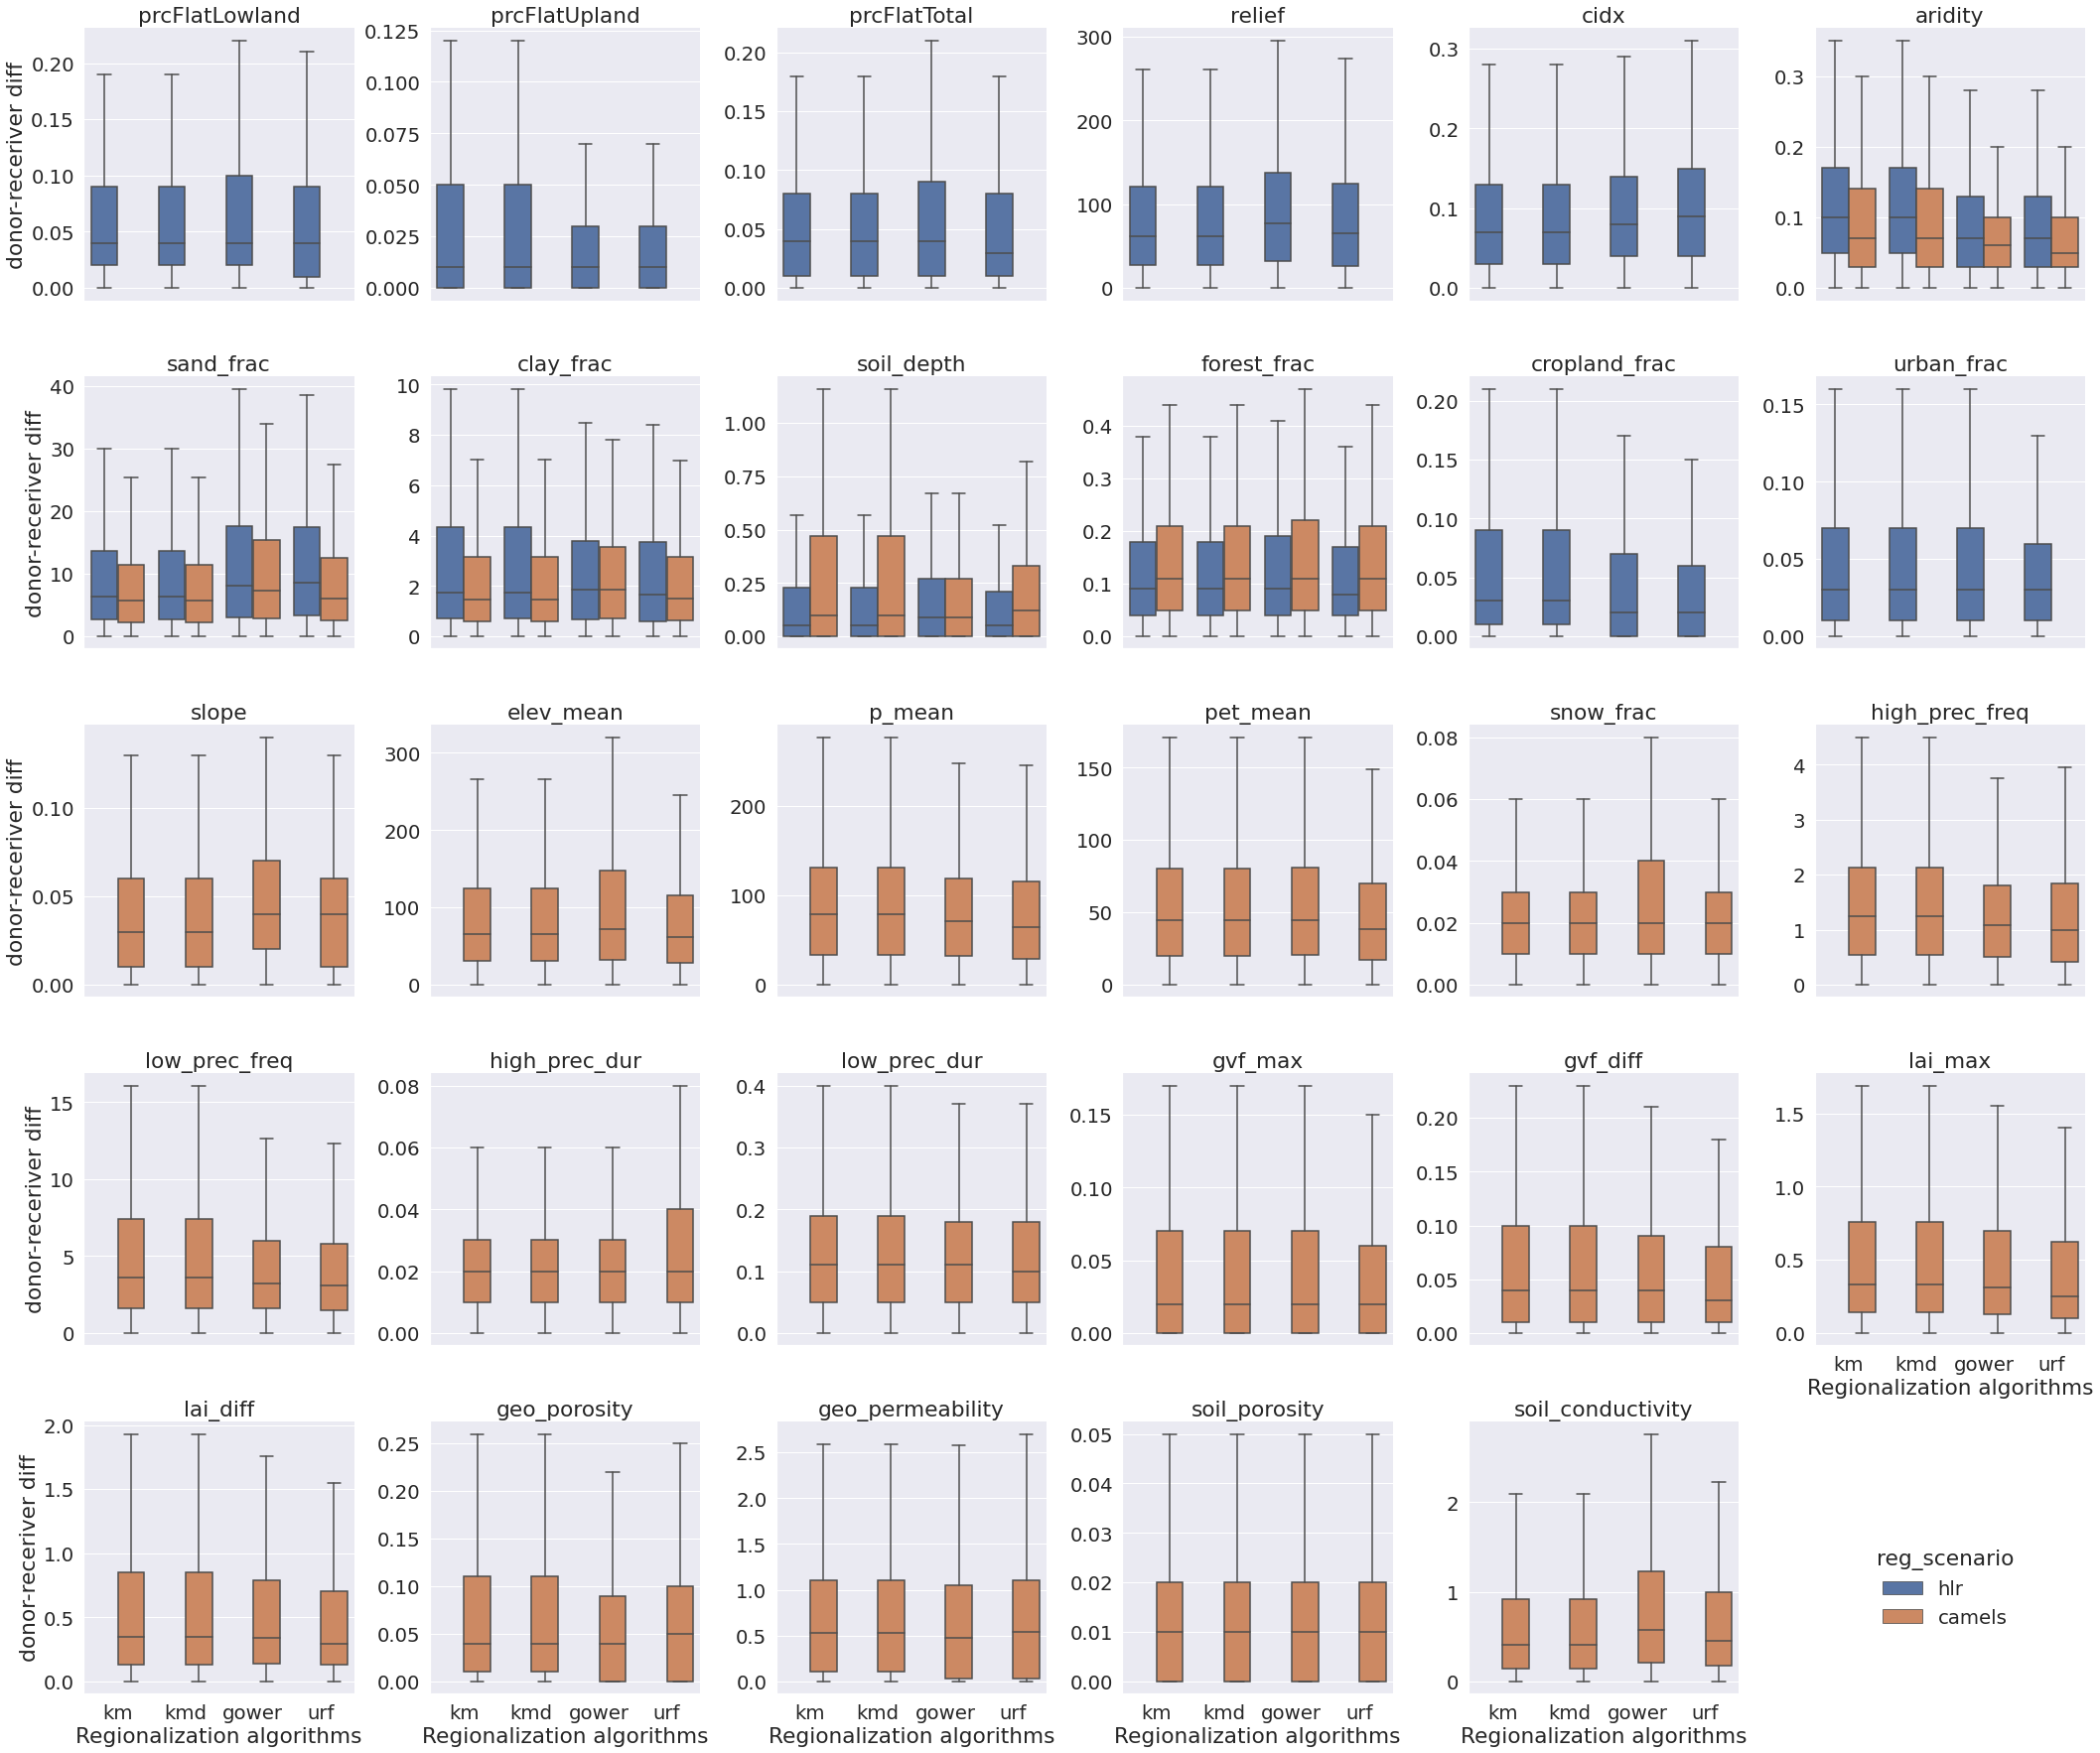

In [90]:
# make boxplots of attribute differences
import seaborn as sns 
import matplotlib.pyplot as plt

sns.set(font_scale=1.8)

dfDiff1 = dfDiff.melt(id_vars=['reg_algorithm','reg_scenario'])
dict = {'kmeans_clust':'km', 'kmedoids_clust':'kmd', 'gower_dist':'gower', 'random_forest':'urf'}
dfDiff1 = dfDiff1.replace({'reg_algorithm': dict})
order = [['kmeans_clust','kmedoids_clust','gower_dist','random_forest']]
g = sns.catplot(data= dfDiff1, kind="box",x="reg_algorithm", y="value", col="variable", col_wrap=6, hue='reg_scenario',
                showfliers = False,sharey=False,legend=True)
g.set_xlabels('Regionalization algorithm')
g.set_ylabels('donor-receriver diff')

for col_key,ax in g.axes_dict.items():
    ax.set_title(col_key)
sns.move_legend(g, "lower right", bbox_to_anchor=(.9, .07))
plt.savefig("../figs/boxplot_attr_diff.png",dpi=500)
